
# 📘 Image Classification Accuracy on Fashion-MNIST Dataset Using ANN, CNN, and Conditional GAN Augmentation





## ⚙️ 1. Imports & Configuration

In [1]:
import os, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.model_selection import train_test_split
except:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "scikit-learn"])
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.model_selection import train_test_split

keras.backend.clear_session()

# ---------------- Configuration ----------------
EAGER = False            # set True only if you hit eager-related errors in your Colab
USE_MIXED = True         # mixed precision helps on T4
BATCH_SIZE = 256
EPOCHS = 20
SEED = 42

np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
tf.config.run_functions_eagerly(EAGER)

if USE_MIXED:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


## 🧩 2. Load the Fashion-MNIST Dataset

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (54000, 28, 28) (54000,)
Val  : (6000, 28, 28) (6000,)
Test : (10000, 28, 28) (10000,)


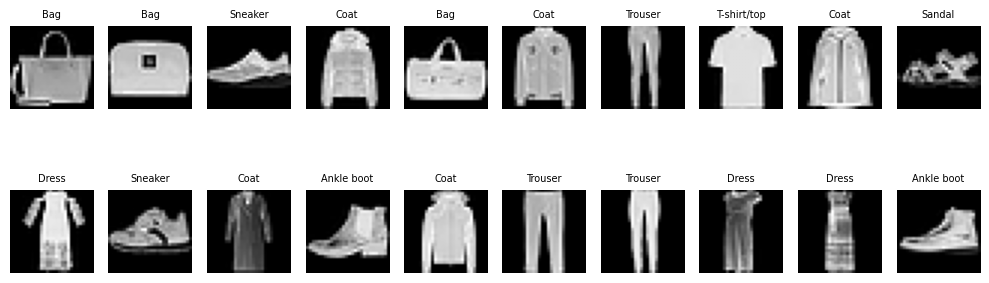

In [2]:

# ---------------- Dataset Load ------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train.astype("float32")/255.0, x_test.astype("float32")/255.0

# stratified split: 10% of train -> validation
x_tr, x_val, y_tr, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

print("Train:", x_tr.shape, y_tr.shape)
print("Val  :", x_val.shape, y_val.shape)
print("Test :", x_test.shape, y_test.shape)

# ---------------- Show samples -----------------
def show_samples(X, y, class_names):
    plt.figure(figsize=(10,4))
    idx = np.random.choice(len(X), 20, replace=False)
    for i, k in enumerate(idx):
        plt.subplot(2,10,i+1)
        plt.imshow(X[k], cmap="gray"); plt.axis("off")
        plt.title(class_names[y[k]], fontsize=7)
    plt.tight_layout(); plt.show()

show_samples(x_train, y_train, class_names)


## 🧮 3. Build ANN and CNN Models

In [3]:

# ---------------- Build ANN --------------------
def build_ann():
    return keras.Sequential([
        layers.Flatten(input_shape=(28,28)),
        layers.Dense(512, activation="relu"), layers.Dropout(0.3),
        layers.Dense(256, activation="relu"), layers.Dropout(0.3),
        layers.Dense(128, activation="relu"), layers.Dropout(0.2),
        layers.Dense(10, activation="softmax", dtype="float32")
    ], name="ANN_FMNIST")

ann = build_ann()
ann.summary()

# ---------------- Build CNN --------------------
def build_cnn():
    inputs = keras.Input(shape=(28,28,1))
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.Conv2D(32,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128,activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(10,activation="softmax",dtype="float32")(x)
    return keras.Model(inputs,outputs,name="CNN_FMNIST")

cnn = build_cnn()
cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "ANN_FMNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

Model: "CNN_FMNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,570 (1.75 MB)

 Trainable params: 458,570 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

## 🧑‍🏫 4. Data Pipeline, Compile & Train

In [4]:

# ---------------- Data pipeline ----------------
AUTOTUNE = tf.data.AUTOTUNE
y_tr_oh, y_val_oh = keras.utils.to_categorical(y_tr,10), keras.utils.to_categorical(y_val,10)
x_tr_cnn, x_val_cnn, x_test_cnn = np.expand_dims(x_tr,-1), np.expand_dims(x_val,-1), np.expand_dims(x_test,-1)

ds_ann_train = tf.data.Dataset.from_tensor_slices((x_tr,y_tr_oh)).shuffle(20000, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_ann_val   = tf.data.Dataset.from_tensor_slices((x_val,y_val_oh)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_cnn_train = tf.data.Dataset.from_tensor_slices((x_tr_cnn,y_tr)).shuffle(20000, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_cnn_val   = tf.data.Dataset.from_tensor_slices((x_val_cnn,y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# ---------------- Compile & Train ----------------
ann.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            metrics=["accuracy"])
cnn.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy"])

# per-model early stopping (ANN patience higher so it can run longer)
cb_ann = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)]
cb_cnn = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]

print("\nTraining ANN...")
hist_ann = ann.fit(ds_ann_train, validation_data=ds_ann_val, epochs=EPOCHS, verbose=2, callbacks=cb_ann)

print("\nTraining CNN...")
hist_cnn = cnn.fit(ds_cnn_train, validation_data=ds_cnn_val, epochs=EPOCHS, verbose=2, callbacks=cb_cnn)



Training ANN...
Epoch 1/20
211/211 - 12s - 55ms/step - accuracy: 0.7701 - loss: 1.0575 - val_accuracy: 0.8567 - val_loss: 0.8399
Epoch 2/20
211/211 - 1s - 4ms/step - accuracy: 0.8476 - loss: 0.8806 - val_accuracy: 0.8742 - val_loss: 0.7925
Epoch 3/20
211/211 - 1s - 3ms/step - accuracy: 0.8629 - loss: 0.8435 - val_accuracy: 0.8768 - val_loss: 0.7733
Epoch 4/20
211/211 - 1s - 3ms/step - accuracy: 0.8692 - loss: 0.8199 - val_accuracy: 0.8783 - val_loss: 0.7638
Epoch 5/20
211/211 - 1s - 4ms/step - accuracy: 0.8764 - loss: 0.7993 - val_accuracy: 0.8873 - val_loss: 0.7506
Epoch 6/20
211/211 - 1s - 4ms/step - accuracy: 0.8798 - loss: 0.7857 - val_accuracy: 0.8887 - val_loss: 0.7403
Epoch 7/20
211/211 - 1s - 3ms/step - accuracy: 0.8830 - loss: 0.7768 - val_accuracy: 0.8862 - val_loss: 0.7436
Epoch 8/20
211/211 - 1s - 4ms/step - accuracy: 0.8835 - loss: 0.7701 - val_accuracy: 0.8915 - val_loss: 0.7354
Epoch 9/20
211/211 - 1s - 6ms/step - accuracy: 0.8891 - loss: 0.7582 - val_accuracy: 0.8960 -

## 📊 5. Evaluation: ANN vs CNN


Test Accuracy - ANN: 0.8889 | CNN: 0.9230

Macro averages:
    Metric    ANN    CNN
 Accuracy 0.8889 0.9230
Precision 0.8891 0.9226
   Recall 0.8889 0.9230
       F1 0.8888 0.9222


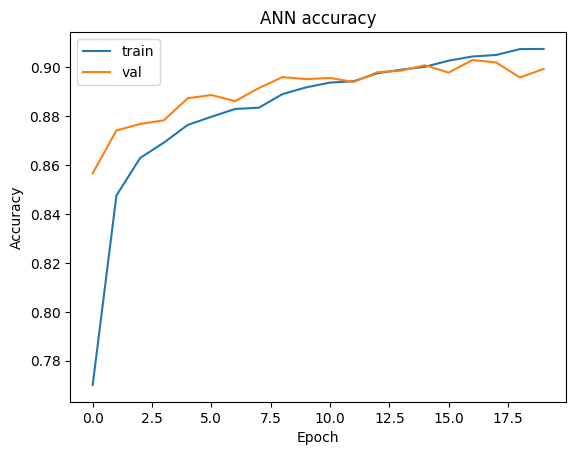

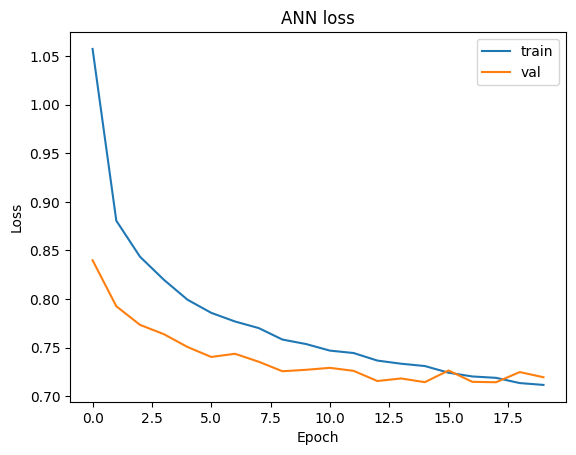

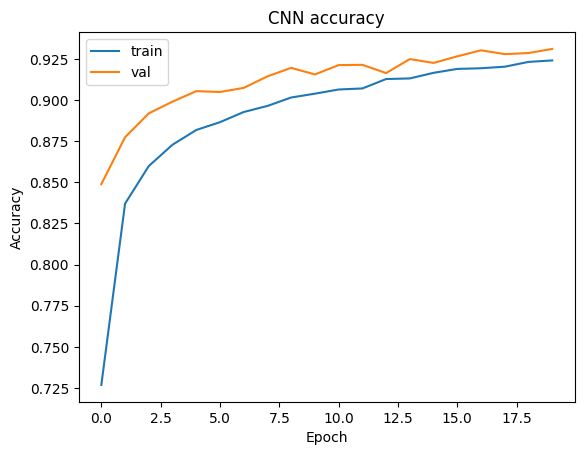

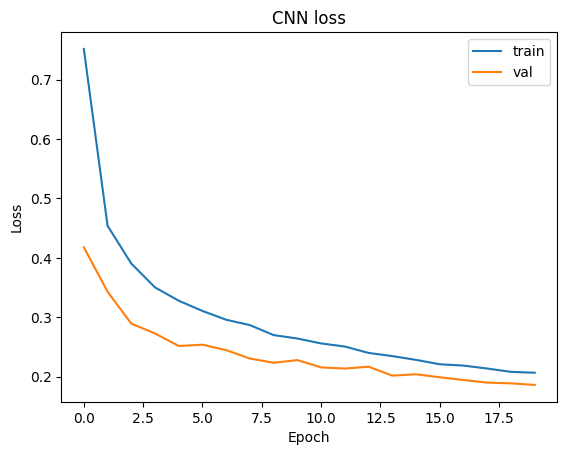

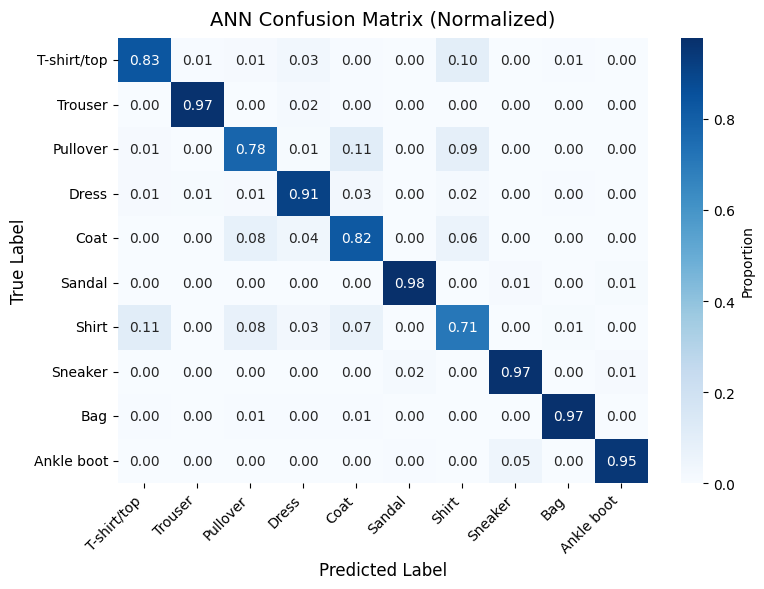

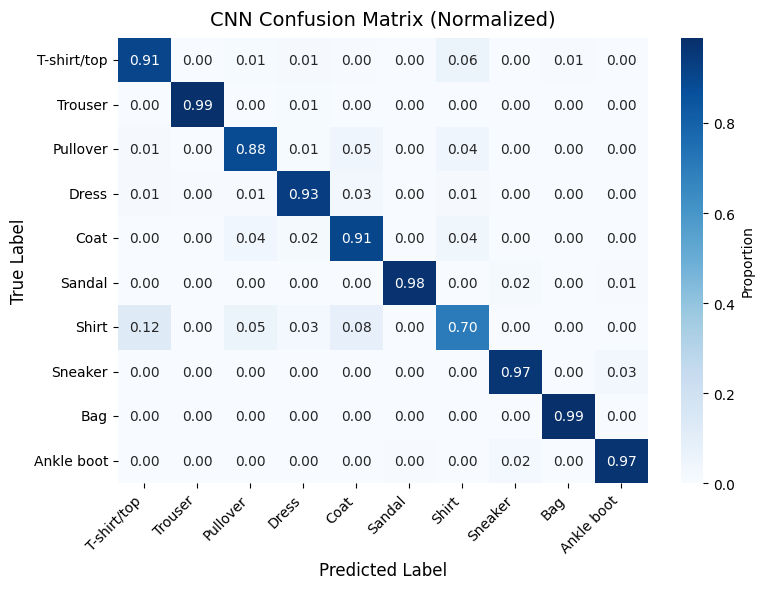

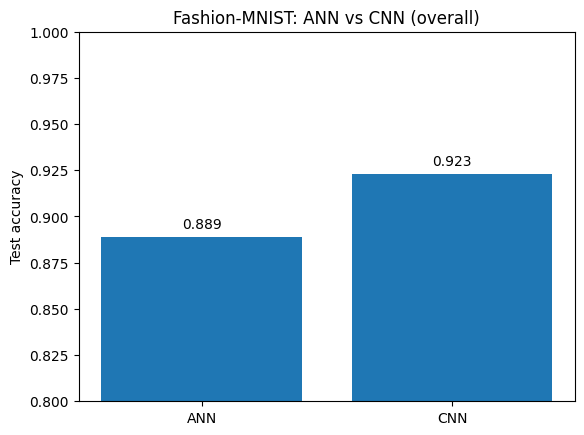

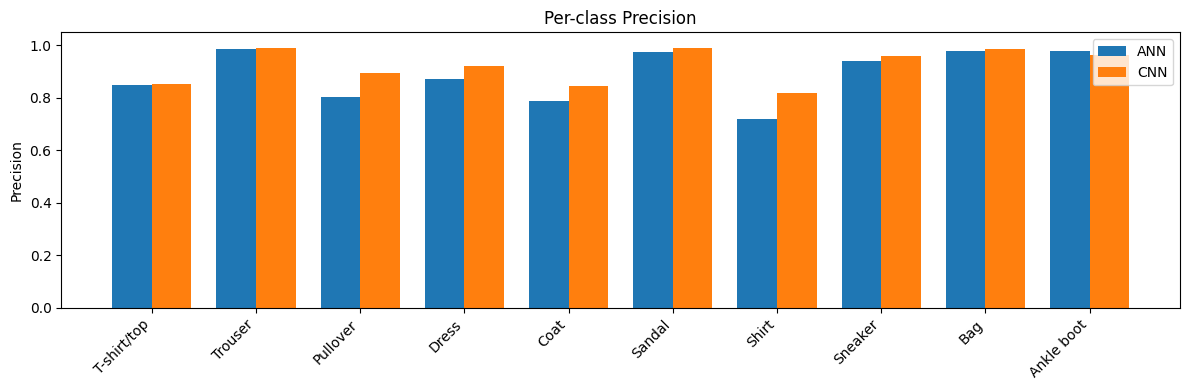

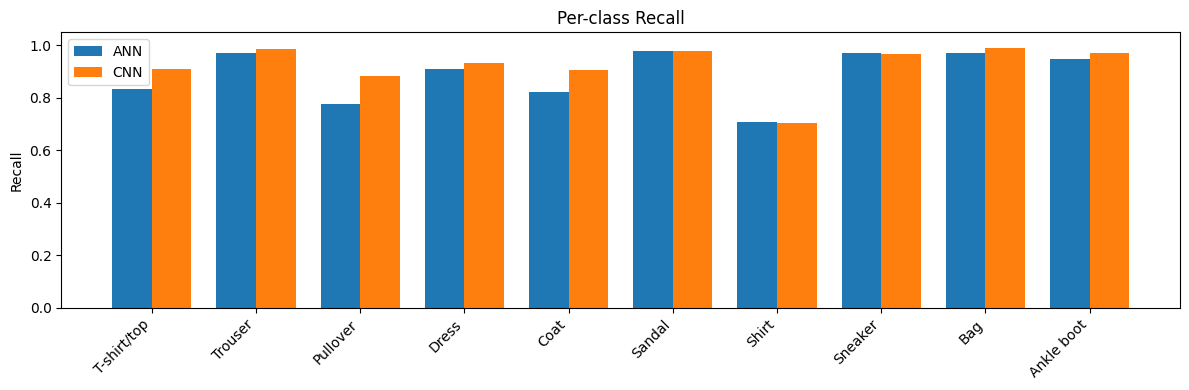

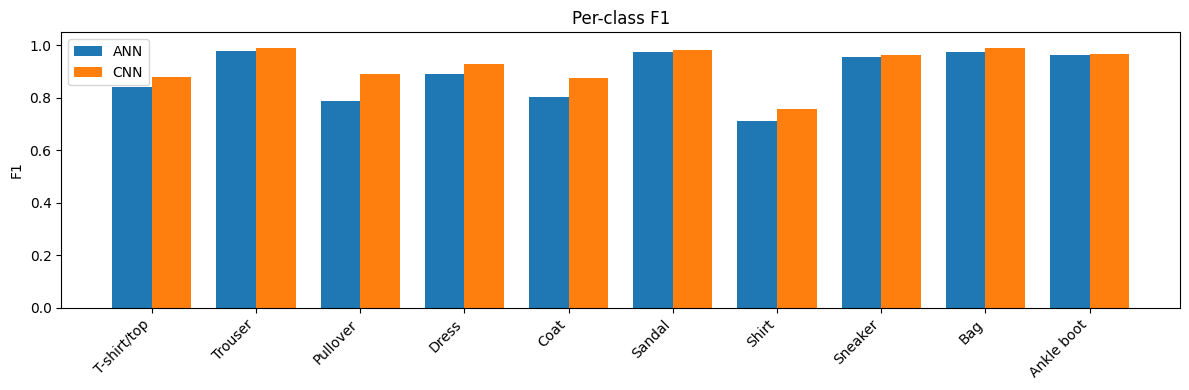

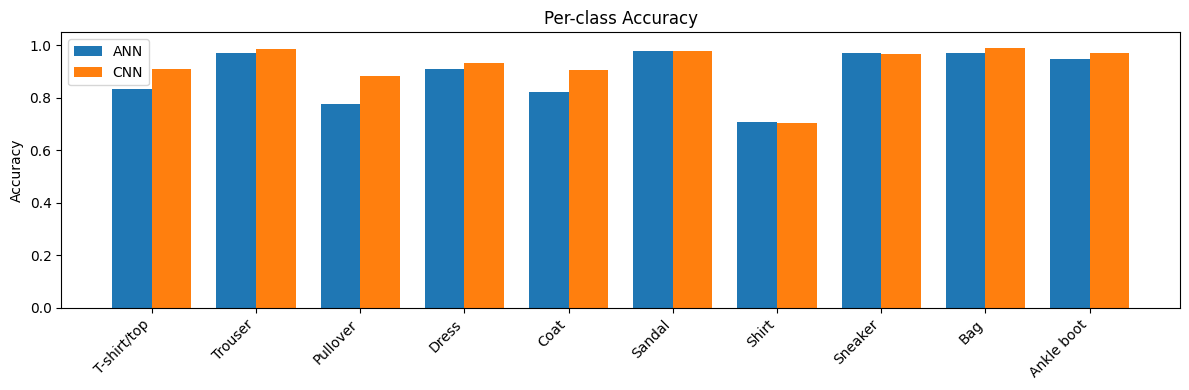

In [5]:

# ---------------- Evaluation -------------------
y_pred_ann = np.argmax(ann.predict(x_test, batch_size=BATCH_SIZE, verbose=0), axis=1)
y_pred_cnn = np.argmax(cnn.predict(x_test_cnn, batch_size=BATCH_SIZE, verbose=0), axis=1)

acc_ann = np.mean(y_pred_ann==y_test)
acc_cnn = np.mean(y_pred_cnn==y_test)
print(f"\nTest Accuracy - ANN: {acc_ann:.4f} | CNN: {acc_cnn:.4f}")

rep_ann = classification_report(y_test,y_pred_ann,target_names=class_names,output_dict=True)
rep_cnn = classification_report(y_test,y_pred_cnn,target_names=class_names,output_dict=True)

def make_summary_tables(rep_dict, acc):
    macro = {"Accuracy":acc,
             "Precision":rep_dict["macro avg"]["precision"],
             "Recall":rep_dict["macro avg"]["recall"],
             "F1":rep_dict["macro avg"]["f1-score"]}
    return macro

macro_ann = make_summary_tables(rep_ann, acc_ann)
macro_cnn = make_summary_tables(rep_cnn, acc_cnn)

macro_table = pd.DataFrame({
    "Metric":["Accuracy","Precision","Recall","F1"],
    "ANN":[f"{macro_ann[m]:.4f}" for m in ["Accuracy","Precision","Recall","F1"]],
    "CNN":[f"{macro_cnn[m]:.4f}" for m in ["Accuracy","Precision","Recall","F1"]],
})
print("\nMacro averages:\n", macro_table.to_string(index=False))

# Confusion matrices + simple plots
cm_ann = confusion_matrix(y_test, y_pred_ann)
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

def plot_history(h, title):
    plt.figure()
    plt.plot(h.history["accuracy"], label="train")
    plt.plot(h.history["val_accuracy"], label="val")
    plt.title(f"{title} accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

    plt.figure()
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.title(f"{title} loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plot_history(hist_ann, "ANN")
plot_history(hist_cnn, "CNN")

def plot_confmat(cm, classes, model_name="Model", normalize=True):

    cm = cm.astype(np.float32)
    if normalize:
        row_sum = cm.sum(axis=1, keepdims=True)
        cm_show = cm / np.maximum(row_sum, 1.0)
        fmt = ".2f"
        cbar_label = "Proportion"
        title = f"{model_name} Confusion Matrix (Normalized)"
    else:
        cm_show = cm
        fmt = "d"
        cbar_label = "Count"
        title = f"{model_name} Confusion Matrix (Counts)"

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        cm_show, annot=True, fmt=fmt, cmap="Blues",
        xticklabels=classes, yticklabels=classes,
        cbar_kws={"label": cbar_label}
    )
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Use (normalized):
plot_confmat(cm_ann, class_names, model_name="ANN", normalize=True)
plot_confmat(cm_cnn, class_names, model_name="CNN", normalize=True)

# Overall ANN vs CNN comparison
plt.figure()
plt.bar(["ANN","CNN"], [acc_ann, acc_cnn])
plt.ylim(0.8, 1.0)
plt.ylabel("Test accuracy")
plt.title("Fashion-MNIST: ANN vs CNN (overall)")
for i, v in enumerate([acc_ann, acc_cnn]):
    plt.text(i, v + 0.003, f"{v:.3f}", ha="center", va="bottom")
plt.show()

# === Per-class metrics (Precision / Recall / F1 / Accuracy) for ANN and CNN ===
def perclass_df(rep_dict, class_names):
    rows = []
    for name in class_names:
        r = rep_dict[name]
        rows.append({
            "Class": name,
            "Precision": r["precision"],
            "Recall": r["recall"],
            "F1": r["f1-score"],
        })
    return pd.DataFrame(rows)

df_ann = perclass_df(rep_ann, class_names)
df_cnn = perclass_df(rep_cnn, class_names)

def perclass_accuracy_from_cm(cm):
    cm = cm.astype(np.float32)
    return np.diag(cm) / np.maximum(cm.sum(axis=1), 1.0)

acc_by_class_ann = perclass_accuracy_from_cm(cm_ann)
acc_by_class_cnn = perclass_accuracy_from_cm(cm_cnn)

def grouped_bars(metric_name, vals_a, vals_b, labels, a_label="ANN", b_label="CNN", ylim=(0.0, 1.05), title_prefix="Per-class"):
    x = np.arange(len(labels))
    w = 0.38
    plt.figure(figsize=(12, 4))
    plt.bar(x - w/2, vals_a, width=w, label=a_label)
    plt.bar(x + w/2, vals_b, width=w, label=b_label)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel(metric_name)
    plt.ylim(*ylim)
    plt.title(f"{title_prefix} {metric_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Precision / Recall / F1
grouped_bars("Precision", df_ann["Precision"].values, df_cnn["Precision"].values, class_names)
grouped_bars("Recall",    df_ann["Recall"].values,    df_cnn["Recall"].values,    class_names)
grouped_bars("F1",        df_ann["F1"].values,        df_cnn["F1"].values,        class_names)

# Per-class Accuracy (derived from confusion matrices)
grouped_bars("Accuracy",  acc_by_class_ann,           acc_by_class_cnn,           class_names, title_prefix="Per-class")


## 🎨 6. Conditional GAN Augmentation (Generator, Discriminator, Training)

In [6]:
# ====================== Targeted + Weighted cGAN Augmentation (compact) ======================
TARGET_CLASSES = [0,2,4,6]  # T-shirt/top, Pullover, Coat, Shirt
LATENT, EPOCHS_GAN, STEPS, REAL_SMOOTH, NOISE_STD = 128, 6, 80, 0.9, 0.05

x_gan = np.expand_dims((x_tr*2.0-1.0).astype("float32"), -1)  # [-1,1]
y_gan = y_tr.astype("int32")

def make_G():
    z_in = keras.Input((LATENT,)); y_in = keras.Input((),dtype="int32")
    y = layers.Embedding(10,LATENT)(y_in); y = layers.Flatten()(y)
    h = layers.Concatenate()([z_in,y])
    h = layers.Dense(7*7*128,use_bias=False)(h)
    h = layers.BatchNormalization()(h); h = layers.LeakyReLU(0.2)(h)
    h = layers.Reshape((7,7,128))(h)
    h = layers.Conv2DTranspose(128,3,strides=2,padding="same",use_bias=False)(h)
    h = layers.BatchNormalization()(h); h = layers.LeakyReLU(0.2)(h)
    h = layers.Conv2DTranspose(64,3,strides=2,padding="same",use_bias=False)(h)
    h = layers.BatchNormalization()(h); h = layers.LeakyReLU(0.2)(h)
    out = layers.Conv2D(1,3,padding="same",activation="tanh", dtype="float32")(h)
    return keras.Model([z_in,y_in],out)

def make_D():
    x_in = keras.Input((28,28,1)); y_in = keras.Input((),dtype="int32")
    y = layers.Embedding(10,28*28)(y_in); y = layers.Reshape((28,28,1))(y)
    h = layers.Concatenate(axis=-1)([x_in,y])
    h = layers.Conv2D(64,3,strides=2,padding="same")(h); h = layers.LeakyReLU(0.2)(h); h = layers.Dropout(0.3)(h)
    h = layers.Conv2D(128,3,strides=2,padding="same")(h); h = layers.LeakyReLU(0.2)(h); h = layers.Dropout(0.3)(h)
    h = layers.Flatten()(h)
    out = layers.Dense(1,activation="sigmoid")(h)
    return keras.Model([x_in,y_in],out)

G, D = make_G(), make_D()
bce = keras.losses.BinaryCrossentropy()
Gopt = keras.optimizers.Adam(1e-4, beta_1=0.5)
Dopt = keras.optimizers.Adam(1e-4, beta_1=0.5)
ds_gan = tf.data.Dataset.from_tensor_slices((x_gan,y_gan)).shuffle(20000, seed=SEED).batch(256)

print("\nTraining cGAN (targeted, weighted)...")
for e in range(1, EPOCHS_GAN+1):
    D_loss = G_loss = 0.0
    steps_ = 0
    for steps_, (rx, ry) in enumerate(ds_gan):
        if steps_ >= STEPS:
            break
        bs = tf.shape(rx)[0]
        z  = tf.random.normal((bs, LATENT))
        fy = tf.random.uniform((bs,), 0, 10, dtype=tf.int32)

        # tiny input noise
        noise_r = tf.random.normal(tf.shape(rx), stddev=NOISE_STD)
        with tf.GradientTape() as d_t, tf.GradientTape() as g_t:
            fx = G([z, fy], training=True)
            noise_f = tf.random.normal(tf.shape(fx), stddev=NOISE_STD)

            # --- IMPORTANT: align dtypes to avoid AddV2 half/float mismatch ---
            rx_cast = tf.cast(rx, tf.float32)
            fx_cast = tf.cast(fx, tf.float32)
            noise_r = tf.cast(noise_r, rx_cast.dtype)
            noise_f = tf.cast(noise_f, fx_cast.dtype)

            rlog = D([rx_cast + noise_r, ry], training=True)
            flog = D([fx_cast + noise_f, fy], training=True)
            # ------------------------------------------------------------------

            d_loss = bce(tf.fill(tf.shape(rlog), REAL_SMOOTH), rlog) + bce(tf.zeros_like(flog), flog)
            g_loss = bce(tf.ones_like(flog), flog)

        Dopt.apply_gradients(zip(d_t.gradient(d_loss, D.trainable_variables), D.trainable_variables))
        Gopt.apply_gradients(zip(g_t.gradient(g_loss, G.trainable_variables), G.trainable_variables))
        D_loss += float(d_loss); G_loss += float(g_loss)

    print(f"GAN Epoch {e}/{EPOCHS_GAN} - D:{D_loss/(steps_+1):.4f} - G:{G_loss/(steps_+1):.4f}")



Training cGAN (targeted, weighted)...
GAN Epoch 1/6 - D:1.2274 - G:0.7162
GAN Epoch 2/6 - D:1.3405 - G:0.7793
GAN Epoch 3/6 - D:1.3683 - G:0.7939
GAN Epoch 4/6 - D:1.3478 - G:0.7882
GAN Epoch 5/6 - D:1.3371 - G:0.7965
GAN Epoch 6/6 - D:1.3470 - G:0.7946


### Quick visual check of generated images (1 per class)

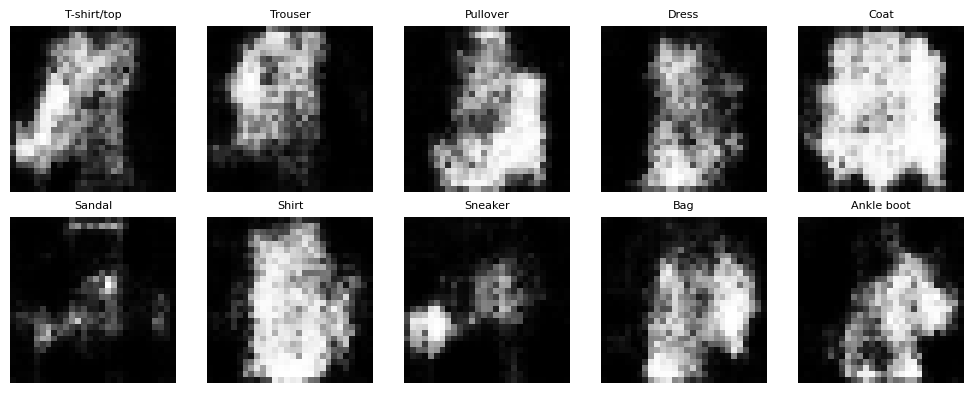

In [7]:

# quick visual check (1 per class)
plt.figure(figsize=(10,4))
for c in range(10):
    z = np.random.normal(size=(1, LATENT)).astype("float32")
    y = np.array([c], dtype="int32")
    img = G.predict([z, y], verbose=0)[0,...,0]
    img = (img+1)/2
    ax = plt.subplot(2,5,c+1); ax.imshow(img, cmap="gray"); ax.axis("off"); ax.set_title(class_names[c], fontsize=8)
plt.tight_layout(); plt.show()


### Generate targeted synthetic samples and filter by discriminator score

In [8]:

# Generate targeted synthetic samples with quality filtering
def gen_for_class(c, n_keep=200):
    over = n_keep*4
    z  = np.random.normal(size=(over, LATENT)).astype("float32")
    yy = np.full((over,), c, dtype="int32")
    f  = G.predict([z, yy], verbose=0)
    s  = D.predict([f, yy], verbose=0).reshape(-1)
    keep = np.argsort(s)[-n_keep:]
    f  = ((f[keep]+1)/2)[...,0].astype("float32")     # back to [0,1]
    return f, np.full((n_keep,), c, dtype="int32")

xs, ys = [], []
for c in range(10):
    if c in TARGET_CLASSES:
        f, yk = gen_for_class(c, n_keep=200)
        xs.append(f); ys.append(yk)

x_syn, y_syn = np.concatenate(xs), np.concatenate(ys)
print("Synthetic filtered set:", x_syn.shape, y_syn.shape)


Synthetic filtered set: (800, 28, 28) (800,)


## 🧾 7. CNN Retraining with Augmented Data (Weighted training)

In [9]:

# Weighted training data (synthetic down-weighted)
x_syn_cnn = np.expand_dims(x_syn, -1)
x_tr_aug  = np.concatenate([x_tr_cnn, x_syn_cnn], axis=0)
y_tr_aug  = np.concatenate([y_tr,     y_syn],     axis=0)
w_tr_aug  = np.concatenate([np.ones(len(x_tr_cnn), dtype="float32"),
                            np.full(len(x_syn_cnn), 0.3, dtype="float32")], axis=0)

ds_aug = tf.data.Dataset.from_tensor_slices((x_tr_aug, y_tr_aug, w_tr_aug))          .shuffle(30000, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_aug = ds_aug.map(lambda x,y,w: (x,y,w))

cnn_aug = build_cnn()
cnn_aug.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

print("\nTraining CNN on augmented data (weighted)...")
cnn_aug.fit(ds_aug, validation_data=ds_cnn_val, epochs=6, verbose=2,
            callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)])

# >>> FIX: recompile with smaller LR (avoid set_value issue)
cnn_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

print("\nFine-tuning CNN on real-only...")
cnn_aug.fit(ds_cnn_train, validation_data=ds_cnn_val, epochs=3, verbose=2)



Training CNN on augmented data (weighted)...
Epoch 1/6
215/215 - 18s - 83ms/step - accuracy: 0.7185 - loss: 0.7549 - val_accuracy: 0.8442 - val_loss: 0.4184
Epoch 2/6
215/215 - 1s - 6ms/step - accuracy: 0.8278 - loss: 0.4582 - val_accuracy: 0.8735 - val_loss: 0.3427
Epoch 3/6
215/215 - 3s - 13ms/step - accuracy: 0.8492 - loss: 0.3965 - val_accuracy: 0.8842 - val_loss: 0.3054
Epoch 4/6
215/215 - 2s - 7ms/step - accuracy: 0.8628 - loss: 0.3606 - val_accuracy: 0.8938 - val_loss: 0.2860
Epoch 5/6
215/215 - 1s - 6ms/step - accuracy: 0.8706 - loss: 0.3377 - val_accuracy: 0.9018 - val_loss: 0.2651
Epoch 6/6
215/215 - 1s - 6ms/step - accuracy: 0.8770 - loss: 0.3223 - val_accuracy: 0.9080 - val_loss: 0.2519

Fine-tuning CNN on real-only...
Epoch 1/3
211/211 - 13s - 62ms/step - accuracy: 0.8958 - loss: 0.2899 - val_accuracy: 0.9100 - val_loss: 0.2376
Epoch 2/3
211/211 - 1s - 6ms/step - accuracy: 0.8977 - loss: 0.2801 - val_accuracy: 0.9125 - val_loss: 0.2347
Epoch 3/3
211/211 - 1s - 6ms/step - 

## ✅ 8. Compare baseline CNN vs CNN (+cGAN)


CNN Macro averages: baseline vs +GAN
   Metric CNN (baseline) CNN (+GAN)
 Accuracy         0.9230     0.8985
Precision         0.9226     0.8982
   Recall         0.9230     0.8985
       F1         0.9222     0.8982


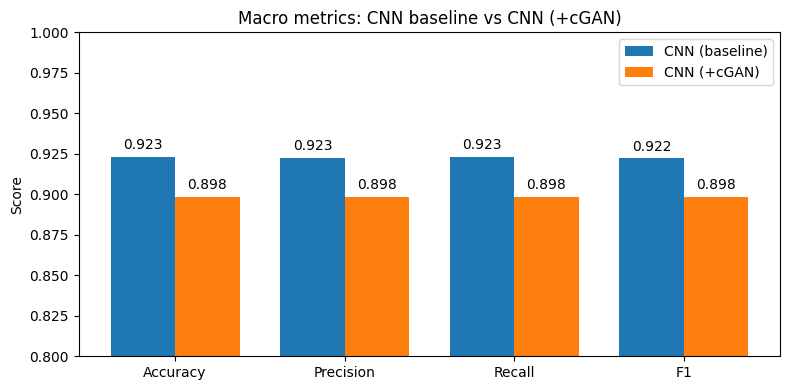

In [10]:

# -------- Compare baseline CNN vs +GAN (macro; no support) --------
y_base = np.argmax(cnn.predict(x_test_cnn, batch_size=BATCH_SIZE, verbose=0), axis=1)
y_aug  = np.argmax(cnn_aug.predict(x_test_cnn, batch_size=BATCH_SIZE, verbose=0), axis=1)

def macro_summary(y_true,y_pred):
    r = classification_report(y_true,y_pred,target_names=class_names,output_dict=True)
    return {
        "Accuracy": float(np.mean(y_true==y_pred)),
        "Precision": r["macro avg"]["precision"],
        "Recall": r["macro avg"]["recall"],
        "F1": r["macro avg"]["f1-score"]
    }

m_base = macro_summary(y_test, y_base)
m_aug  = macro_summary(y_test, y_aug)

print("\nCNN Macro averages: baseline vs +GAN")
print(pd.DataFrame({
    "Metric":["Accuracy","Precision","Recall","F1"],
    "CNN (baseline)":[f"{m_base[m]:.4f}" for m in ["Accuracy","Precision","Recall","F1"]],
    "CNN (+GAN)":[f"{m_aug[m]:.4f}"     for m in ["Accuracy","Precision","Recall","F1"]],
}).to_string(index=False))

# === Macro metric comparison bars: CNN baseline vs CNN + cGAN ===
macro_labels = ["Accuracy", "Precision", "Recall", "F1"]
vals_base = [m_base[k] for k in macro_labels]
vals_aug  = [m_aug[k]  for k in macro_labels]

x = np.arange(len(macro_labels))
w = 0.38

plt.figure(figsize=(8, 4))
plt.bar(x - w/2, vals_base, width=w, label="CNN (baseline)")
plt.bar(x + w/2, vals_aug,  width=w, label="CNN (+cGAN)")
plt.xticks(x, macro_labels)
plt.ylim(0.8, 1.0)
plt.ylabel("Score")
plt.title("Macro metrics: CNN baseline vs CNN (+cGAN)")
for i, v in enumerate(vals_base):
    plt.text(i - w/2, v + 0.003, f"{v:.3f}", ha="center", va="bottom")
for i, v in enumerate(vals_aug):
    plt.text(i + w/2, v + 0.003, f"{v:.3f}", ha="center", va="bottom")
plt.legend()
plt.tight_layout()
plt.show()



## 💬 Conclusion

**What we did:** built ANN and CNN models, trained and evaluated them, implemented a targeted cGAN to augment data for selected classes, retrained a CNN with synthetic samples (weighted), and compared performance.


